## Telco Churn Classification Project

by David Rodriguez 2021/11/29

In [1]:
# import modules
from os.path import isfile
from env import host, user, password
from pathlib import Path

# import warnings
import warnings
warnings.filterwarnings("ignore")

# import pandas, numpy, os and DataFrame
import pandas as pd
import numpy as np
from pandas import DataFrame

# import various other tools
import seaborn as sns
import matplotlib.pyplot as plt
import math
from scipy import stats

# import models and train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

## Project Goal

The goal of this project is to analyze the telco dataset and identify why over 25% of customers are leaving telco for a different service provider. Uncovering this information will help develop recommendations to improve customer retention.

## Project Description

As a data scientist, one should strive to find insights in data and 
make the maximum possible use of data. In a setting like Telco, a data
scientist could be pivotal in identifying and developing a strategy to
retain customers who are leaving for other companies. In the case of Telco, over 25% of customers have left over the course of 6 years. 
Customers leaving a company is part of the industry and in a way, unavoidable. However, that doesn't mean a company cannot be competitive and develop strategies to minimize customer bleeding and ideally reversing the negative trend into customer expansion. In this exercise, we try to look into the data and look for pointers that can help develop savvy business strategies with the goal of improving customer retention.

## Initial Questions

The initial questions are why are customers leaving? What can be done to improve customer retention? Could something be done about it? Should plan prices be reconsidered? Should additional bundles be implemented?

## Data Dictionary

In [2]:
# creating data dictionary
data_dict = [['payment_type_id', 'Payment type key. Depending on id, it could be one of the following: electronic check, mailed check, bank transfer or credit card'], ['internet_service_type_id', 'Internet service key. Depending on id, it could be one of the following: DSL, fiber optic or none'], ['contract_type_id', 'Contract type key. Depending on id, it could be one of the following: month to month, two year or one year'],
       ['customer_id', 'Customer id number'], ['gender', 'Customer gender'], ['senior_citizen', 'Whether the customer is a senior citizen'], ['partner', 'Whether the customer has a partner'], ['dependents', 'Whether the customer has dependents'],
       ['tenure', 'Customer length with Telco in months'], ['phone_service', 'Whether the customer has phone service'], ['multiple_lines', 'Whether the customer has multiple lines or no phone service'], ['online_security', 'Whether the customer has online security or no internet service'],
       ['online_backup', 'Whether the customer has online backup or no internet service'], ['device_protection', 'Whether the customer has device protecion or no internet service'], ['tech_support', 'Whether the customer has tech support or no internet service'], ['streaming_tv', 'Whether the customer has streaming tv services or no internet service'],
       ['streaming_movies', 'Whether the customer has streaming movie services or no internet service'], ['paperless_billing', 'Whether customer is enrolled in paperless billing'], ['monthly_charges', 'Monthly charges for customer'],
       ['total_charges', 'To date charges to customers'], ['churn', 'Whether the cusomer has churned or not'], ['contract_type', 'The type of contract the customer has'], ['internet_service_type', 'The type of internet service the customer has'],
       ['payment_type', 'The type of payment method by the customer']]
data_dict = pd.DataFrame(data_dict, columns = ['Variable', 'Description'])
pd.set_option('display.max_colwidth', None)

In [3]:
data_dict

,Variable,Description
0,payment_type_id,"Payment type key. Depending on id, it could be one of the following: electronic check, mailed check, bank transfer or credit card"
1,internet_service_type_id,"Internet service key. Depending on id, it could be one of the following: DSL, fiber optic or none"
2,contract_type_id,"Contract type key. Depending on id, it could be one of the following: month to month, two year or one year"
3,customer_id,Customer id number
4,gender,Customer gender
5,senior_citizen,Whether the customer is a senior citizen
6,partner,Whether the customer has a partner
7,dependents,Whether the customer has dependents
8,tenure,Customer length with Telco in months
9,phone_service,Whether the customer has phone service


## Wrangle Data
To acquire the telco data, the telco_db from the mySQL codeup was used. The query used to get the data was:

SELECT * FROM customers
                JOIN contract_types USING(contract_type_id)
                JOIN internet_service_types USING(internet_service_type_id)
                JOIN payment_types USING(payment_type_id);

In [4]:
def get_connection(db, user = user, host = host, password = password):
    '''
    This function takes in as arguments the database, username, host, and password for 
    the mysql database and returns a string that can be used to open a connection to the server
    and query the db in the read_sql function. 
    '''
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'

In [5]:
def telco_data():
    '''
    This function reads the telco data from the Codeup db into a df,
    write it to a csv file, and returns the df.
    '''
    # Create SQL query.
    sql_query = """
                SELECT * FROM customers
                JOIN contract_types USING(contract_type_id)
                JOIN internet_service_types USING(internet_service_type_id)
                JOIN payment_types USING(payment_type_id);
                """
    
    # Read in DataFrame from Codeup db.
    df = pd.read_sql(sql_query, get_connection('telco_churn'))
    
    return df

In [6]:
def save_telco_data():
    '''
    This function takes the telco data from the Codeup db, saves it to a csv file and if it does not exist
    in the local drive, saves the file as a csv.
    '''
    
    if os.path.isfile('telco_df.csv'):
        # If telco DataFrame is saved to local drive, the file is read from the local drive
        df = pd.read_csv('telco.csv', index_col = 0)
        
    else:
        # Read telco data from Codeup db
        df = telco_data()
        
        # Save DataFrame to CSV file
        df.to_csv('telco.csv')
        
    return df

In [7]:
df = telco_data()

In [8]:
df.head()

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,2,1,3,0016-QLJIS,Female,0,Yes,Yes,65,Yes,...,Yes,Yes,Yes,Yes,90.45,5957.9,No,Two year,DSL,Mailed check
1,4,1,3,0017-DINOC,Male,0,No,No,54,No,...,Yes,Yes,No,No,45.20,2460.55,No,Two year,DSL,Credit card (automatic)
2,3,1,3,0019-GFNTW,Female,0,No,No,56,No,...,Yes,No,No,No,45.05,2560.1,No,Two year,DSL,Bank transfer (automatic)
3,4,1,3,0056-EPFBG,Male,0,Yes,Yes,20,No,...,Yes,No,No,Yes,39.40,825.4,No,Two year,DSL,Credit card (automatic)
4,3,1,3,0078-XZMHT,Male,0,Yes,No,72,Yes,...,Yes,Yes,Yes,Yes,85.15,6316.2,No,Two year,DSL,Bank transfer (automatic)


To clean the data, I did the following:
1. Dropped duplicate values and columns
1. Replaces values 'No phone service' and 'No internet' to 'No'
1. Updates the data type of the total_charges column
1. transforms type columns minus churn into dummy variables
1. Drops 12 rows of missing data from the total_charges column.


In [9]:
def clean_telco(df):
    '''
    This functions takes in the telco_db combined into a single dataframe as an argument,
    drops duplicate values and columns, replaces values 'No phone service' and 'No internet 
    service' to 'No', updates the data type of the total_charges column, transforms object 
    type columns, minus churn, into dummies and drops parent dummy columns. Since drop_first is
    set to false, dummy no columns are dropped and senior citizen is renamed and changed its
    type for consistency purposes. Finally, the function drops 12 rows of data from missing 
    values in the total_charges column.
    '''
    df.drop_duplicates(inplace = True)
    df.replace(to_replace = {'No phone service':'No', 'No internet service':'No'}, inplace = True)
    dropped_columns = ['payment_type_id', 'internet_service_type_id', 'contract_type_id',
       'customer_id']
    df_dropped = df.drop(columns = dropped_columns)
    df_dropped = df_dropped.replace(r'^\s*$', np.nan, regex = True)
    df_dropped.total_charges = df_dropped.total_charges.astype('float64')
    # no need for dummies on exploration.
    #obj_cols_name = df_dropped.columns[[df_dropped[col].dtype == 'object' for col in df_dropped.columns]]
    #obj_cols_name = obj_cols_name.to_list()
    #obj_cols_name.remove('churn')
    #df_dummies = pd.get_dummies(df_dropped[obj_cols_name], drop_first = False)
    #df_concat = pd.concat([df_dropped, df_dummies], axis = 1)
    #df_concat = df_concat.drop(columns = obj_cols_name)
    #dummy_no = [ 'partner_No', 'dependents_No', 'phone_service_No', 'multiple_lines_No', 
    #        'online_security_No', 'online_backup_No', 'device_protection_No', 
    #        'tech_support_No', 'streaming_tv_No', 'streaming_movies_No',
    #        'paperless_billing_No',]
    #dummy_drop = df_concat.drop(columns = dummy_no)
    #dummy_drop.rename(columns = {'senior_citizen':'senior_citizen_Yes'}, inplace = True)
    #dummy_drop.senior_citizen_Yes = dummy_drop.senior_citizen_Yes.astype('uint8')
    #df_cleaned = dummy_drop[dummy_drop.total_charges.notnull()]
    df_dropped['monthly_avg'] = df_dropped['total_charges']/df_dropped['tenure'] 
    
    return df_dropped

In [10]:
def train_validate_test_split(df, seed = 123):
    '''
    This functions takes in the cleanted telco dataframe as an argument and a random seed, and splits 
    the dataframe into train, validate and test samples. The test size is 20% of the data, the validate
    size is 24% of the data and the train is 56% of the data. Finally, the function returns 3 dataframes:
    train, validate and test.
    '''    
    train_and_validate, test = train_test_split(
            df, test_size = 0.2, random_state = seed, stratify = df.churn
                                                )
    train, validate = train_test_split(
            train_and_validate, 
            test_size = 0.3, 
            random_state = seed, 
            stratify = train_and_validate.churn
                                       )
    return train, validate, test

 - Data is split into three sets, train, validate and test
 - train will be used to implement the model, validate will help verify its accuracy and the best performing model will be applied to the test dataset

In [13]:
df = clean_telco(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   gender                 7043 non-null   object 
 1   senior_citizen         7043 non-null   int64  
 2   partner                7043 non-null   object 
 3   dependents             7043 non-null   object 
 4   tenure                 7043 non-null   int64  
 5   phone_service          7043 non-null   object 
 6   multiple_lines         7043 non-null   object 
 7   online_security        7043 non-null   object 
 8   online_backup          7043 non-null   object 
 9   device_protection      7043 non-null   object 
 10  tech_support           7043 non-null   object 
 11  streaming_tv           7043 non-null   object 
 12  streaming_movies       7043 non-null   object 
 13  paperless_billing      7043 non-null   object 
 14  monthly_charges        7043 non-null   float64
 15  tota

In [15]:
# let's fix senior_citizen dtype
df.senior_citizen = df.senior_citizen.replace({0:'No', 1:'Yes'})

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   gender                 7043 non-null   object 
 1   senior_citizen         7043 non-null   object 
 2   partner                7043 non-null   object 
 3   dependents             7043 non-null   object 
 4   tenure                 7043 non-null   int64  
 5   phone_service          7043 non-null   object 
 6   multiple_lines         7043 non-null   object 
 7   online_security        7043 non-null   object 
 8   online_backup          7043 non-null   object 
 9   device_protection      7043 non-null   object 
 10  tech_support           7043 non-null   object 
 11  streaming_tv           7043 non-null   object 
 12  streaming_movies       7043 non-null   object 
 13  paperless_billing      7043 non-null   object 
 14  monthly_charges        7043 non-null   float64
 15  tota

## Exploratory Analysis

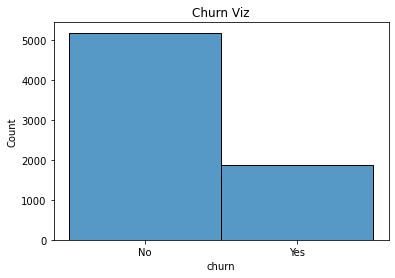

In [17]:
plt.title('Churn Viz')
sns.histplot(df.churn)
plt.show();

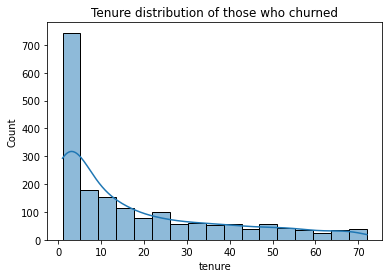

In [18]:
plt.title('Tenure distribution of those who churned')
sns.histplot(df[df['churn'] == 'Yes'].tenure, kde = True)
plt.show();

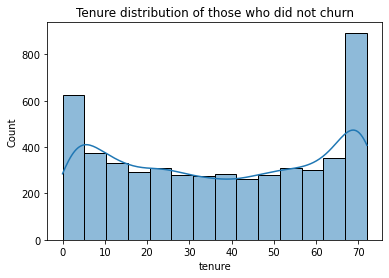

In [19]:
plt.title('Tenure distribution of those who did not churn')
sns.histplot(df[df['churn'] == 'No'].tenure, kde = True)
plt.show();

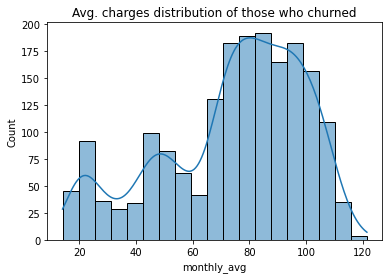

In [20]:
plt.title('Avg. charges distribution of those who churned')
sns.histplot(df[df['churn'] == 'Yes'].monthly_avg, kde = True)
plt.show();

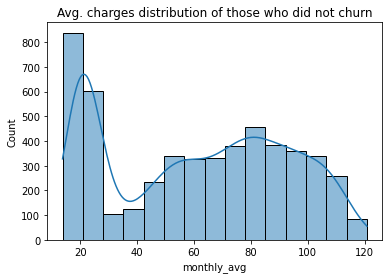

In [21]:
plt.title('Avg. charges distribution of those who did not churn')
sns.histplot(df[df['churn'] == 'No'].monthly_avg, kde = True)
plt.show();

Who is more likely to churn?
Those who don't have a long tenure and those who have high monthly average bills.

In [22]:
# split dataframe into different object types
o_qualitatives = df.columns[[df[col].dtype == 'object' for col in df.columns]]
f_quantitatives = df.columns[[df[col].dtype == 'float64' for col in df.columns]]
i_quantitatives = df.columns[[df[col].dtype == 'int64' for col in df.columns]]

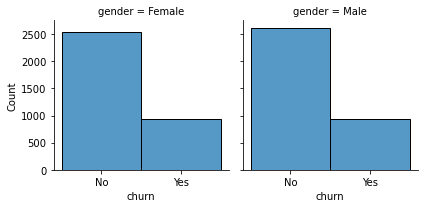

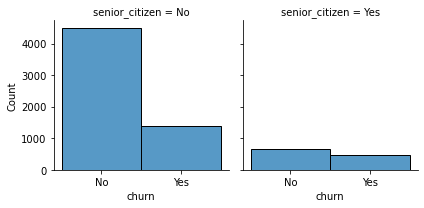

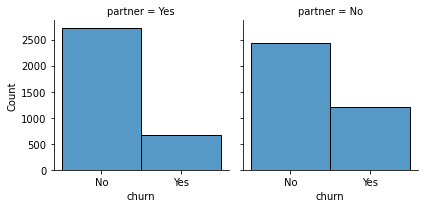

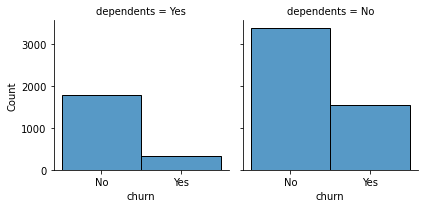

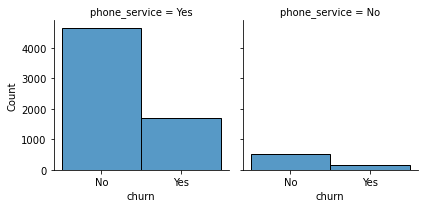

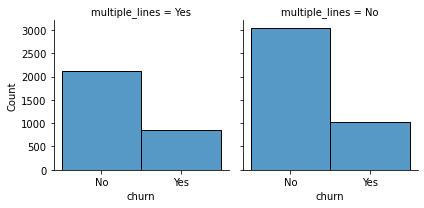

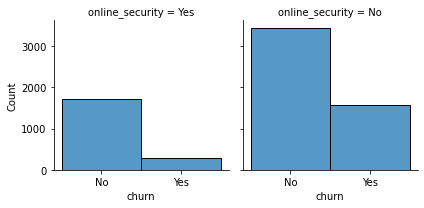

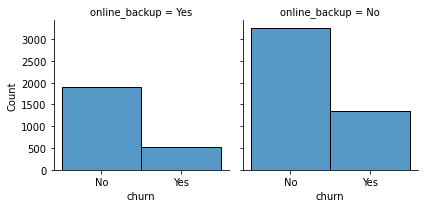

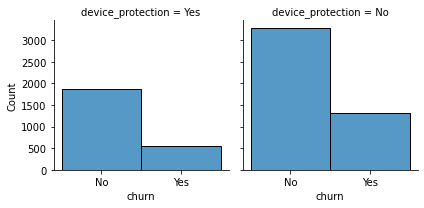

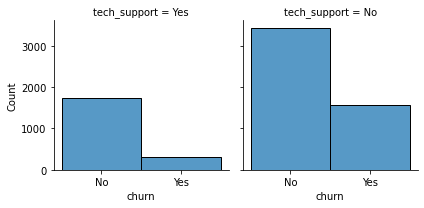

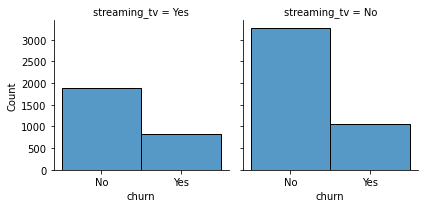

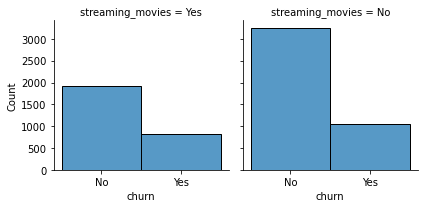

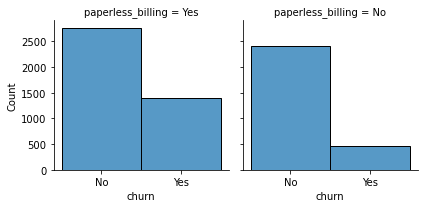

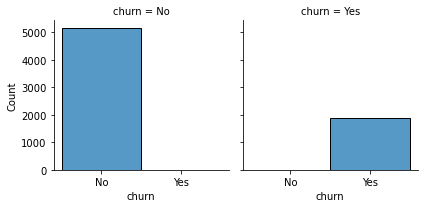

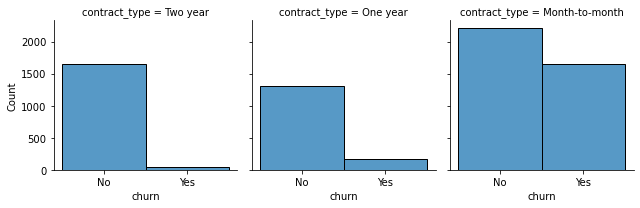

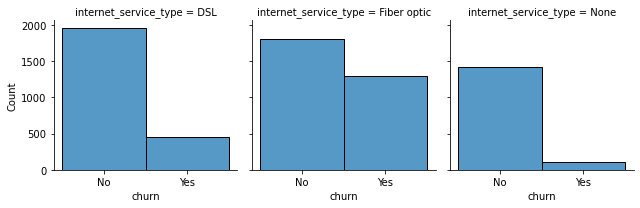

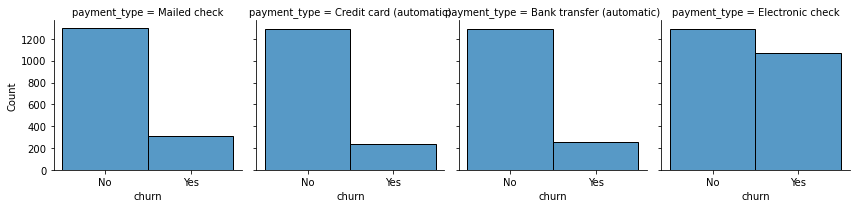

In [23]:
for column in o_qualitatives:
    sns.FacetGrid(df, col = column).map(sns.histplot, 'churn')
    plt.show();

In [ ]:
# contract type month to month, fiber optic clients, and electronic
# check paying customers seem to have a higher than usual churn rate

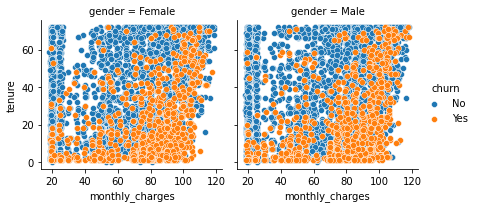

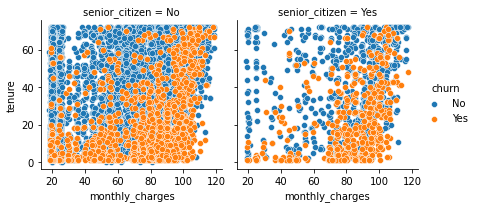

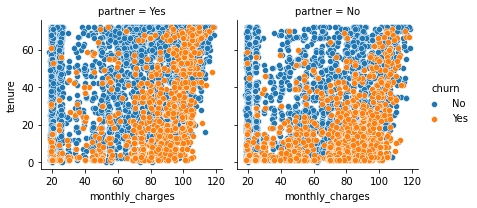

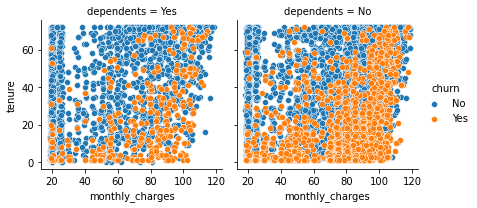

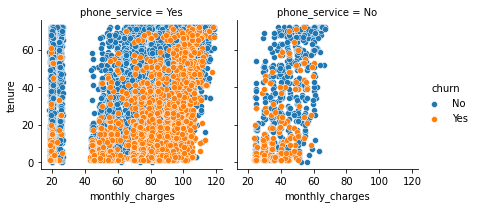

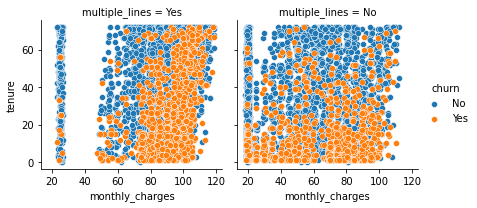

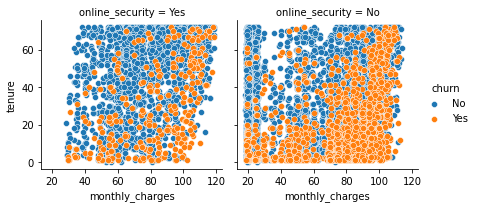

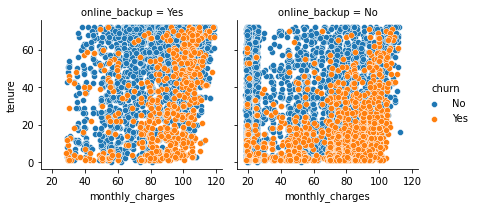

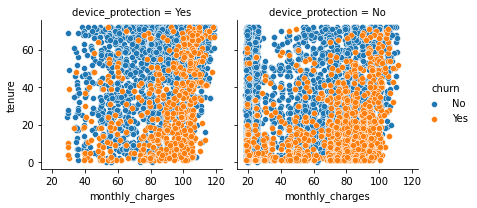

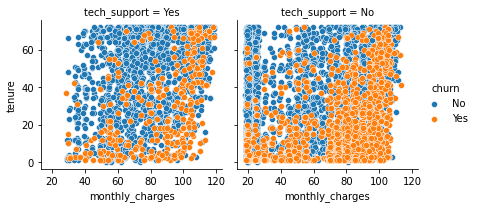

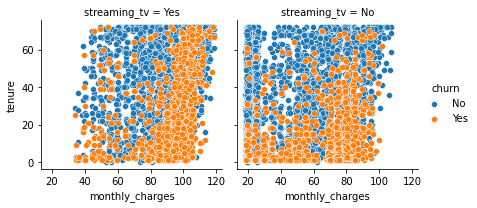

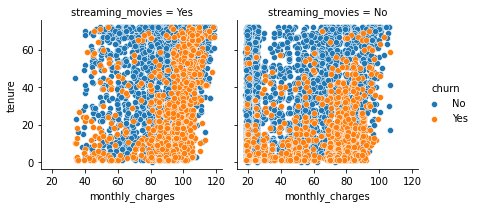

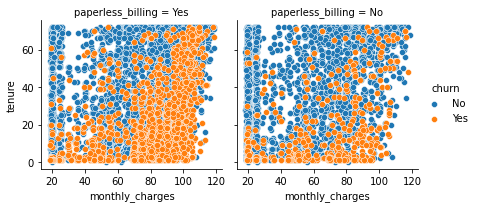

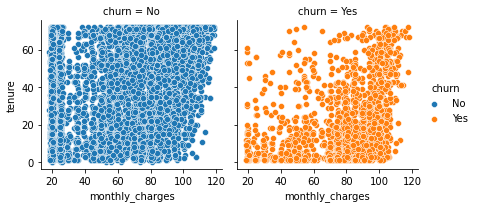

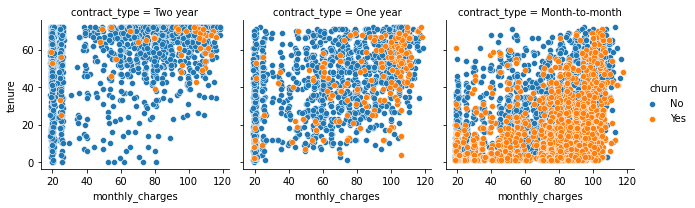

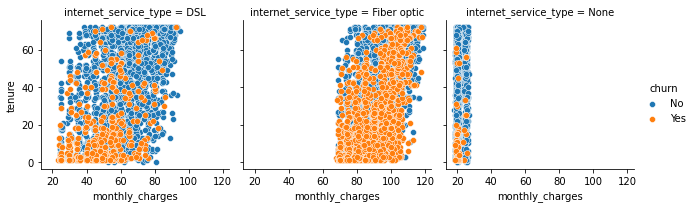

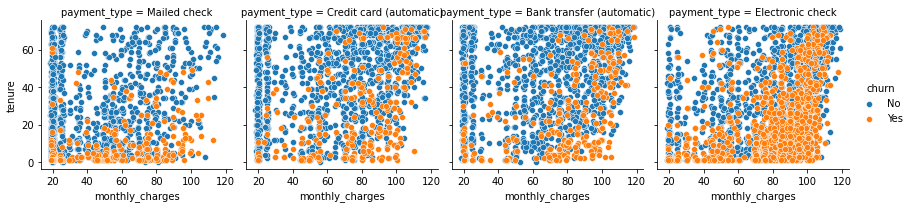

In [25]:
for column in o_qualitatives:
    sns.FacetGrid(df, col = column, hue = 'churn').map(sns.scatterplot, 'monthly_charges', 'tenure').add_legend()

In [26]:
for col in o_qualitatives:
    observed = pd.crosstab(df[col], df['churn'])
    chi2, p, degf, expected = stats.chi2_contingency(observed)
    chi2_summary = pd.DataFrame({'chi2': [chi2], 'p': [p], 'degrees of freedom': [degf]})
    expected = pd.DataFrame(expected)
    print('observed')
    print(observed)
    print('')
    print(chi2_summary)
    print('')
    print('expected')
    print(expected)
    print('')
    print('----------------------------------------------')
    print('')

observed
churn     No  Yes
gender           
Female  2549  939
Male    2625  930

       chi2         p  degrees of freedom
0  0.484083  0.486579                   1

expected
             0           1
0  2562.389891  925.610109
1  2611.610109  943.389891

----------------------------------------------

observed
churn             No   Yes
senior_citizen            
No              4508  1393
Yes              666   476

       chi2             p  degrees of freedom
0  159.4263  1.510067e-36                   1

expected
             0            1
0  4335.052392  1565.947608
1   838.947608   303.052392

----------------------------------------------

observed
churn      No   Yes
partner            
No       2441  1200
Yes      2733   669

         chi2             p  degrees of freedom
0  158.733382  2.139911e-36                   1

expected
           0         1
0  2674.7883  966.2117
1  2499.2117  902.7883

----------------------------------------------

observed
churn         No  

Which features are not independent?
gender, phone service and multiple lines are not independent due to a higher p value in comparison with the other features.

In [ ]:
for i in o_qualitatives:
    print('Churn = Yes')
    print(pd.pivot_table(df[df['churn'] == 'Yes'], index = i, values = 'monthly_charges'))
    print('Churn = No')
    print(pd.pivot_table(df[df['churn'] == 'No'], index = i, values = 'monthly_charges'))
    print('')
    print('-----------------------------------------------')
    print('')

Is being charged more indicative of churn?
It looks like it does. monthly charges for those who churn do have higher costs.

## Modeling

In [ ]:
df.monthly_charges.describe()

In [ ]:
df.monthly_avg.describe()

In [ ]:
# let's drop the three dependent variables (gender, phone service and multiple lines) as well as total charges 
# (not needed because customers tend to churn early on) and average monthly charges (since it's quite similar to
# monthly_charges)

In [ ]:
df.churn.value_counts()

In [ ]:
df_baseline = df
df_baseline['baseline_pred'] = 'No'

In [ ]:
baseline_accuracy = (df_baseline.baseline_pred == df.churn).mean()

print(f'baseline accuracy: {baseline_accuracy:.2%}')

In [ ]:
def clean_split_telco(df):
    '''
    This function runs both the clean_titanic and train_validate_test_split functions. This functins takes
    in as argument the telco dataframe from the SQL pull, cleans it, splits it, and returns 3 dataframes:
    train, validate and test.
    '''
    cleaned_df = clean_telco(df)
    train, validate, test = train_validate_test_split(cleaned_df, seed = 123)
    return train, validate, test

In [ ]:
def clean_telco(df):
    '''
    This functions takes in the telco_db combined into a single dataframe as an argument,
    drops duplicate values and columns, replaces values 'No phone service' and 'No internet 
    service' to 'No', updates the data type of the total_charges column, transforms object 
    type columns, minus churn, into dummies and drops parent dummy columns. Since drop_first is
    set to false, dummy no columns are dropped and senior citizen is renamed and changed its
    type for consistency purposes. Finally, the function drops 12 rows of data from missing 
    values in the total_charges column.
    '''
    df.drop_duplicates(inplace = True)
    df.replace(to_replace = {'No phone service':'No', 'No internet service':'No'}, inplace = True)
    dropped_columns = ['payment_type_id', 'internet_service_type_id', 'contract_type_id',
       'customer_id']
    df_dropped = df.drop(columns = dropped_columns)
    df_dropped = df_dropped.replace(r'^\s*$', np.nan, regex = True)
    df_dropped.total_charges = df_dropped.total_charges.astype('float64')
    obj_cols_name = df_dropped.columns[[df_dropped[col].dtype == 'object' for col in df_dropped.columns]]
    obj_cols_name = obj_cols_name.to_list()
    obj_cols_name.remove('churn')
    df_dummies = pd.get_dummies(df_dropped[obj_cols_name], drop_first = False)
    df_concat = pd.concat([df_dropped, df_dummies], axis = 1)
    df_concat = df_concat.drop(columns = obj_cols_name)
    dummy_no = [ 'partner_No', 'dependents_No', 'phone_service_No', 'multiple_lines_No', 
            'online_security_No', 'online_backup_No', 'device_protection_No', 
            'tech_support_No', 'streaming_tv_No', 'streaming_movies_No',
            'paperless_billing_No',]
    dummy_drop = df_concat.drop(columns = dummy_no)
    dummy_drop.rename(columns = {'senior_citizen':'senior_citizen_Yes'}, inplace = True)
    dummy_drop.senior_citizen_Yes = dummy_drop.senior_citizen_Yes.astype('uint8')
    df_cleaned = dummy_drop[dummy_drop.total_charges.notnull()]
    df_cleaned['monthly_avg'] = df_cleaned['total_charges']/df_cleaned['tenure'] 
    
    return df_cleaned

In [ ]:
df = telco_data()

In [ ]:
train, validate, test = clean_split_telco(df)

In [ ]:
train.info()

In [ ]:
# drop unnecessary columns
train = train.drop(columns = ['gender_Female', 'gender_Male', 'phone_service_Yes', 'multiple_lines_Yes', 'total_charges', 'monthly_avg'])
validate = validate.drop(columns = ['gender_Female', 'gender_Male', 'phone_service_Yes', 'multiple_lines_Yes', 'total_charges', 'monthly_avg'])
test = test.drop(columns = ['gender_Female', 'gender_Male', 'phone_service_Yes', 'multiple_lines_Yes', 'total_charges', 'monthly_avg'])

In [ ]:
# decision tree
X_train = train.drop(columns=['churn'])
y_train = train.churn

X_validate = validate.drop(columns=['churn'])
y_validate = validate.churn

X_test = test.drop(columns=['churn'])
y_test = test.churn

In [ ]:
for i in range(1, 16):
    print('max_depth value: {}'.format(i))
    dtc = DecisionTreeClassifier(max_depth = i, random_state = 123)
    dtc = dtc.fit(X_train, y_train)
    y_pred = dtc.predict(X_train)
    print('Accuracy of Decision Tree classifier on training set: {:.2f}'.format(dtc.score(X_train, y_train)))
    print(classification_report(y_train, y_pred))
    print('Accuracy of Decision Tree classifier on validate set: {:.2f}'.format(dtc.score(X_validate, y_validate)))
    y_pred = dtc.predict(X_validate)
    print(classification_report(y_validate, y_pred))
    print('-------------------------------------------------')

In [ ]:
dtc_graph = []
for i in range(1, 16):
    dtc = DecisionTreeClassifier(max_depth = i, random_state = 123)
    dtc = dtc.fit(X_train, y_train)
    y_pred = dtc.predict(X_train)
    dtc_evaluation_df = {"max_depth": i, "train_accuracy": dtc.score(X_train, y_train), "validate_accuracy": dtc.score(X_validate, y_validate)}
    dtc_graph.append(dtc_evaluation_df)

dtc_accuracy_graph = pd.DataFrame(dtc_graph)

dtc_accuracy_graph.set_index('max_depth', inplace = True)
dtc_accuracy_graph.plot(figsize = (12,4))
plt.ylabel('Accuracy')
plt.xticks(np.arange(0,16,1))
plt.grid(b = True)

In [ ]:
# max depth value of 5 is ideal at 78 validate accuracy

In [ ]:
# random forest
for i in range(1, 16):
    print('max_depth value: {}'.format(i))
    rf = RandomForestClassifier(max_depth = i,
                           random_state = 123, 
                           min_samples_leaf = 1)
    rf = rf.fit(X_train, y_train)
    y_pred = rf.predict(X_train)
    print('Accuracy of Random Forest classifier on training set: {:.2f}'.format(rf.score(X_train, y_train)))
    print(classification_report(y_train, y_pred))
    print('Accuracy of Random Forest classifier on validate set: {:.2f}'.format(rf.score(X_validate, y_validate)))
    y_pred = rf.predict(X_validate)
    print(classification_report(y_validate, y_pred))
    print('-------------------------------------------------')

In [ ]:
rf_graph = []
for i in range(1, 16):
    rf = RandomForestClassifier(max_depth = i,
                           random_state = 123, 
                           min_samples_leaf = 1)
    rf = rf.fit(X_train, y_train)
    y_pred = rf.predict(X_train)
    rf_evaluation_df = {"max_depth": i, "train_accuracy": rf.score(X_train, y_train), "validate_accuracy": rf.score(X_validate, y_validate)}
    rf_graph.append(rf_evaluation_df)

rf_accuracy_graph = pd.DataFrame(rf_graph)

rf_accuracy_graph.set_index('max_depth', inplace = True)
rf_accuracy_graph.plot(figsize = (12,4))
plt.ylabel('Accuracy')
plt.xticks(np.arange(0,16,1))
plt.grid(b = True)

In [ ]:
# max depth value of 5 is ideal at 80 validate accuracy

In [ ]:
# knn
for i in range(1, 16):
    print('n value: {}'.format(i))
    knn = KNeighborsClassifier(n_neighbors = i, weights = 'uniform')
    knn = knn.fit(X_train, y_train)
    y_pred = knn.predict(X_train)
    print('Accuracy of KNN classifier on training set: {:.2f}'.format(knn.score(X_train, y_train)))
    print(classification_report(y_train, y_pred))
    print('Accuracy of KNN classifier on validate set: {:.2f}'.format(knn.score(X_validate, y_validate)))
    y_pred = knn.predict(X_validate)
    print(classification_report(y_validate, y_pred))
    print('-------------------------------------------------')

In [ ]:
knn_graph = []
for i in range(1, 16):
    knn = KNeighborsClassifier(n_neighbors = i, weights = 'uniform')
    knn = knn.fit(X_train, y_train)
    y_pred = knn.predict(X_train)
    knn_evaluation_df = {"max_depth": i, "train_accuracy": knn.score(X_train, y_train), "validate_accuracy": knn.score(X_validate, y_validate)}
    knn_graph.append(knn_evaluation_df)

knn_accuracy_graph = pd.DataFrame(knn_graph)

knn_accuracy_graph.set_index('max_depth', inplace = True)
knn_accuracy_graph.plot(figsize = (12,4))
plt.ylabel('Accuracy')
plt.xticks(np.arange(0,16,1))
plt.grid(b = True)

In [ ]:
# max depth value of 13 is ideal at 79 validate accuracy

In [ ]:
# logistic regression
for i in np.arange(.1, 1.6, .1):
    print('C value: {}'.format(i))
    lr = LogisticRegression(C = i, random_state = 123)
    lr = lr.fit(X_train, y_train)
    y_pred = lr.predict(X_train)
    print('Accuracy of Logistic Regression classifier on training set: {:.2f}'.format(lr.score(X_train, y_train)))
    print(classification_report(y_train, y_pred))
    print('Accuracy of Logistic Regression classifier on validate set: {:.2f}'.format(lr.score(X_validate, y_validate)))
    y_pred = lr.predict(X_validate)
    print(classification_report(y_validate, y_pred))
    print('-------------------------------------------------')

In [ ]:
lr_graph = []
for i in np.arange(.1, 1.6, .1):
    lr = LogisticRegression(C = i, random_state = 123)
    lr = lr.fit(X_train, y_train)
    y_pred = lr.predict(X_train)
    lr_evaluation_df = {"max_depth": i, "train_accuracy": lr.score(X_train, y_train), "validate_accuracy": lr.score(X_validate, y_validate)}
    lr_graph.append(lr_evaluation_df)

lr_accuracy_graph = pd.DataFrame(lr_graph)

lr_accuracy_graph.set_index('max_depth', inplace = True)
lr_accuracy_graph.plot(figsize = (12,4))
plt.ylabel('Accuracy')
plt.xticks(np.arange(0,1.6,.1))
plt.grid(b = True)

In [ ]:
# random forest at max depth value 5 performs best, 80%
rf = RandomForestClassifier(max_depth = 5,
                           random_state = 123, 
                           min_samples_leaf = 1)
rf.fit(X_train, y_train)
print('Accuracy of random forest classifier on train set: {:.2f}'.format(rf.score(X_train, y_train)))
print('Accuracy of random forest classifier on validate set: {:.2f}'.format(rf.score(X_validate, y_validate)))
print('Accuracy of random forest classifier on test set: {:.2f}'.format(rf.score(X_test, y_test)))

In [ ]:
# save csv to local drive
y_prediction = rf.predict(X_test)
test_probability = rf.predict_proba(X_test)
test_probability_df = pd.concat([X_test.reset_index(), pd.DataFrame(test_probability, columns = ['Did not churn', 'Churned'])], axis = 1)
test_probability_df['predictions'] = rf.predict(X_test)
test_probability_df = test_probability_df[['index', 'Did not churn', 'Churned', 'predictions']]
df = telco_data()
predictions = test_probability_df.merge(df, left_on = 'index', right_index = True)
predictions = predictions[['customer_id', 'Did not churn', 'Churned', 'predictions']]
predictions.set_index('customer_id', inplace = True)
predictions.to_csv('predictions.csv')

## Conclusion

 - A to curve customer churn would be to offer discounted rates for customers who sign up for new service. It would be ideal to keep these discounted amount for at least a year in order to let customers see the value in what they are paying
 - Another recommendation would be to offer more variety in bundling of services. As observed, fiber optics customers tend to leave at higher rates than those who have DSL. Perhaps offering discounted fiber optic service or bundling it with additional features could help customers see the value in that service too.
 - A third recommendation would be to phase out month-to-month contracts into a one year or two year contract as those on a month-to-month plan leaver at higher rates than those on one and two year contracts.

## Next Steps
 - Further analysis of the telco churn dataset to identify additional reasons why customers are churning.
 - Monitoring of the implemented recommendations to see if there's any reversa of the churning trend.